<a href="https://colab.research.google.com/github/HadenMoore/DS-Unit-1-Sprint-1-Dealing-With-Data/blob/master/module1-afirstlookatdata/LS_DS_111_A_First_Look_at_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science - A First Look at Data



## Lecture - let's explore Python DS libraries and examples!

The Python Data Science ecosystem is huge. You've seen some of the big pieces - pandas, scikit-learn, matplotlib. What parts do you want to see more of?

In [0]:
# TODO - we'll be doing this live, taking requests
# and reproducing what it is to look up and learn things

myList = [50, 42, 29, 75, 50, 82]

**bold text** This is new text

## Assignment - now it's your turn

Pick at least one Python DS library, and using documentation/examples reproduce in this notebook something cool. It's OK if you don't fully understand it or get it 100% working, but do put in effort and look things up.

# Something New? Or did I delete something? You decide





In [0]:
from __future__ import division
import numpy as np
from scipy.special import factorial
import scipy.stats as stats
import pylab
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")
import ipywidgets
from IPython.display import display
from matplotlib.font_manager import FontProperties
fontP = FontProperties()
fontP.set_size('medium')
%config InlineBackend.figure_format = 'svg'


def mean_firing_rate(gain, stimulus, preferred_stimulus, std_tc, baseline):
    # Gaussian tuning curve that determines the mean firing rate (Poisson rate parameter) for a given stimulus
    return baseline + gain*stats.norm.pdf(preferred_stimulus, loc = stimulus, scale = std_tc)

def get_spikes(gain, stimulus, preferred_stimuli, std_tc, baseline):
    # produce a vector of spikes for some population given some stimulus
    lambdas = mean_firing_rate(gain, stimulus, preferred_stimuli, std_tc, baseline)
    return np.random.poisson(lambdas)
                
def likelihood(stimulus, r, gain, preferred_stimuli, std_tc, baseline):
    # returns p(r|s)
    lambdas = mean_firing_rate(gain, stimulus, preferred_stimuli, std_tc, baseline)
    return np.prod(lambdas**r)

def spikes_and_inference(r_V = True,
                         r_A = True,
                         show_tuning_curves = False,
                         show_spike_count = False,
                         show_likelihoods = True,
                         true_stimulus = 10,
                         number_of_neurons = 40,
                         r_V_gain = 15,
                         r_A_gain = 75,
                         r_V_tuning_curve_sigma = 10,
                         r_A_tuning_curve_sigma = 10,
                         tuning_curve_baseline = 0,
                         joint_likelihood = True,
                         r_V_plus_r_A = True,
                         cue = False):
    np.random.seed(7)
    max_s = 40
    preferred_stimuli = np.linspace(-max_s*2, max_s*2, number_of_neurons)
    n_hypothesized_s = 250
    hypothesized_s = np.linspace(-max_s, max_s, n_hypothesized_s)
    gains     = {'r1':    r_V_gain,
                 'r2':    r_A_gain,
                 'r1+r2': r_V_gain + r_A_gain}
    sigma_TCs = {'r1':    r_V_tuning_curve_sigma,
                 'r2':    r_A_tuning_curve_sigma,
                 'r1+r2': (r_V_tuning_curve_sigma + r_A_tuning_curve_sigma)/2}
    spikes    = {'r1':    get_spikes(gains['r1'], true_stimulus, preferred_stimuli, sigma_TCs['r1'], tuning_curve_baseline),
                 'r2':    get_spikes(gains['r2'], true_stimulus, preferred_stimuli, sigma_TCs['r2'], tuning_curve_baseline)}
    spikes['r1+r2'] = spikes['r1'] + spikes['r2']
    active_pops = []
    if r_V: active_pops.append('r1')
    if r_A: active_pops.append('r2')
    if r_V_plus_r_A: active_pops.append('r1+r2')

    colors = {'r1':    sns.xkcd_rgb['light purple'],
              'r2':    sns.xkcd_rgb['dark pink'],
              'r1+r2': sns.xkcd_rgb['royal blue'],
              'joint': sns.xkcd_rgb['gold']}
    nSubplots = show_spike_count + show_tuning_curves + show_likelihoods
    fig, axes = plt.subplots(nSubplots, figsize = (7, 1.5*nSubplots)) # number of subplots according to what's been requested
    if not isinstance(axes, np.ndarray): axes = [axes] # makes axes into a list even if it's just one subplot
    subplot_idx = 0
    
    def plot_true_stimulus_and_legend(subplot_idx):
        axes[subplot_idx].plot(true_stimulus, 0, 'k^', markersize = 12, clip_on = False, label = 'true rattlesnake location')
        axes[subplot_idx].legend(loc = 'center left', bbox_to_anchor = (1, 0.5), prop = fontP)
    
    if show_tuning_curves:
        for neuron in range(number_of_neurons):
            if r_V:
                axes[subplot_idx].plot(hypothesized_s,
                                       mean_firing_rate(gains['r1'],
                                                        hypothesized_s,
                                                        preferred_stimuli[neuron],
                                                        sigma_TCs['r1'],
                                                        tuning_curve_baseline),
                                       color = colors['r1'])
            if r_A:
                axes[subplot_idx].plot(hypothesized_s,
                                       mean_firing_rate(gains['r2'],
                                                        hypothesized_s,
                                                        preferred_stimuli[neuron],
                                                        sigma_TCs['r2'],
                                                        tuning_curve_baseline),
                                       color = colors['r2'])
        axes[subplot_idx].set_xlabel('location $s$')
        axes[subplot_idx].set_ylabel('mean firing rate\n(spikes/s)')
        axes[subplot_idx].set_ylim((0, 4))
        axes[subplot_idx].set_xlim((-40, 40))
        axes[subplot_idx].set_yticks(np.linspace(0, 4, 5))
        subplot_idx += 1

    if show_spike_count:
        idx = abs(preferred_stimuli) < max_s
        if r_V:
            axes[subplot_idx].plot(preferred_stimuli[idx], spikes['r1'][idx], 'o', color = colors['r1'],
                                   clip_on = False,  label = '$\mathbf{r}_\mathrm{V}$',
                                   markersize=4)
        if r_A:
            axes[subplot_idx].plot(preferred_stimuli[idx], spikes['r2'][idx], 'o', color = colors['r2'],
                                   clip_on = False, label = '$\mathbf{r}_\mathrm{A}$',
                                   markersize=4)
        if r_V_plus_r_A:
            axes[subplot_idx].plot(preferred_stimuli[idx], spikes['r1+r2'][idx], 'o', color = colors['r1+r2'],
                                   clip_on = False, label = '$\mathbf{r}_\mathrm{V}+\mathbf{r}_\mathrm{A}$',
                                   markersize=8, zorder=1)
        axes[subplot_idx].set_xlabel('preferred location')
        axes[subplot_idx].set_ylabel('spike count')
        axes[subplot_idx].set_ylim((0, 10))
        axes[subplot_idx].set_xlim((-40, 40))
        plot_true_stimulus_and_legend(subplot_idx)
        subplot_idx += 1

    if show_likelihoods:
        if cue:
            var = 'c'
        else:
            var = '\mathbf{r}'
        likelihoods = {}
            
        for population in active_pops:
            likelihoods[population] = np.zeros_like(hypothesized_s)
            for idx, ort in enumerate(hypothesized_s):
                likelihoods[population][idx] = likelihood(ort, spikes[population], gains[population],
                                                          preferred_stimuli, sigma_TCs[population], tuning_curve_baseline)
            likelihoods[population] /= np.sum(likelihoods[population]) # normalize

        if r_V:
            axes[subplot_idx].plot(hypothesized_s, likelihoods['r1'], color = colors['r1'],
                                   linewidth = 2, label = '$p({}_\mathrm{{V}}|s)$'.format(var))
        if r_A:
            axes[subplot_idx].plot(hypothesized_s, likelihoods['r2'], color = colors['r2'],
                                   linewidth = 2, label = '$p({}_\mathrm{{A}}|s)$'.format(var))
        if r_V_plus_r_A:
            axes[subplot_idx].plot(hypothesized_s, likelihoods['r1+r2'], color = colors['r1+r2'],
                                   linewidth = 2, label = '$p({}_\mathrm{{V}}+{}_\mathrm{{A}}|s)$'.format(var, var))
        if joint_likelihood:
            product = likelihoods['r1']*likelihoods['r2']
            product /= np.sum(product)
            axes[subplot_idx].plot(hypothesized_s, product, color = colors['joint'],linewidth = 7,
                                   label = '$p({}_\mathrm{{V}}|s)\ p({}_\mathrm{{A}}|s)$'.format(var, var), zorder = 1)

        axes[subplot_idx].set_xlabel('location $s$')
        axes[subplot_idx].set_ylabel('probability')
        axes[subplot_idx].set_xlim((-40, 40))
        axes[subplot_idx].legend()
        axes[subplot_idx].set_yticks([])
        
        plot_true_stimulus_and_legend(subplot_idx)
        subplot_idx += 1

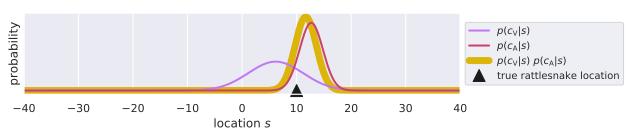

In [124]:
spikes_and_inference(show_likelihoods = True, r_V_plus_r_A = False, cue = True)


### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  Describe in a paragraph of text what you did and why, as if you were writing an email to somebody interested but nontechnical.

2.  What was the most challenging part of what you did?

3.  What was the most interesting thing you learned?

4.  What area would you like to explore with more time?




1.)I initially imported a few Python libraries in order to have the code cell run the way I need it to.n I had to give the cell the correct code in order to produce the graph. Such as labeling the x & y axis, and having the cell create the graph only if the code is correct. 
2.) The most challenging part was trying to search for a notebook I could recreate that had the data still available. Some of the CSV Files were broken, and I was unable to have it read correctly. 
3.) The most interesting thing I learned today is that there is a VAST amount of things that Python can do. It's incredible. 
4.) I'd like to explore the creation of 3D Images and graphs in python. 

## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub (and since this is the first assignment of the sprint, open a PR as well).

- [pandas documentation](https://pandas.pydata.org/pandas-docs/stable/)
- [scikit-learn documentation](http://scikit-learn.org/stable/documentation.html)
- [matplotlib documentation](https://matplotlib.org/contents.html)
- [Awesome Data Science](https://github.com/bulutyazilim/awesome-datascience) - a list of many types of DS resources

Stretch goals:

- Find and read blogs, walkthroughs, and other examples of people working through cool things with data science - and share with your classmates!
- Write a blog post (Medium is a popular place to publish) introducing yourself as somebody learning data science, and talking about what you've learned already and what you're excited to learn more about.